<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por caracteres


# **Desafío 3**

### Alumno **Daniel Fernando Herrera** (a1621)

#### Texto seleccionado **Viaje al Centro de la Tierra**, de Julio Verne
https://www.textos.info/julio-verne/viaje-al-centro-de-la-tierra/ebook

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [2]:
# descargar de textos.info
import urllib.request

# Para leer y parsear el texto en HTML de wikipedia
import bs4 as bs

In [3]:
raw_html = urllib.request.urlopen('https://www.textos.info/julio-verne/viaje-al-centro-de-la-tierra/ebook')
raw_html = raw_html.read()

# Parsear artículo, 'lxml' es el parser a utilizar
article_html = bs.BeautifulSoup(raw_html, 'lxml')

# Encontrar todos los párrafos del HTML (bajo el tag <p>)
# y tenerlos disponible como lista
article_paragraphs = article_html.find_all('p')

article_text = ''

for para in article_paragraphs:
    article_text += para.text + ' '

# pasar todo el texto a minúscula
article_text = article_text.lower()

In [4]:
# en article text se encuentra el texto de todo el libro
article_text[:1000]

' el domingo 24 de mayo de 1863, mi tío, el profesor lidenbrock, entró \r\nrápidamente a su hogar, situado en el número 19 de la könig‑strasse, una\r\n de las calles más tradicionales del barrio antiguo de hamburgo. marta, su excelente criada, se preocupó sobremanera, creyendo que se \r\nhabía retrasado, pues apenas empezaba a cocinar la comida en el \r\nhornillo. “bueno” —pensé para mí—, “si mi tío viene con hambre, se va a armar \r\nla de san quintín; porque no conozco a otro hombre de menos paciencia”. —¡tan temprano y ya está aquí el señor lidenbrock! —exclamó la pobre marta, con arrebol, entreabriendo la puerta del comedor. —sí, marta; pero tú no tienes la culpa de que la comida no esté lista\r\n todavía, porque es temprano, aún no son las dos. acaba de dar la media \r\nhora en san miguel. —¿y por qué ha venido tan pronto el señor lidenbrock? —él lo explicará, seguramente. —¡ahí viene! yo me escapo. señor axel, cálmelo usted, por favor. y la excelente marta se retiró presurosa a s

#### **Normalizar saltos de línea y espacios múltiples.**

>Se observa repetidamente '\r\n' que corresponde a saltos de líneas. Se realiza una limpieza del texto.

In [5]:
import re
article_text = re.sub(r'\s+', ' ', article_text)


In [6]:
article_text[:1000]

' el domingo 24 de mayo de 1863, mi tío, el profesor lidenbrock, entró rápidamente a su hogar, situado en el número 19 de la könig‑strasse, una de las calles más tradicionales del barrio antiguo de hamburgo. marta, su excelente criada, se preocupó sobremanera, creyendo que se había retrasado, pues apenas empezaba a cocinar la comida en el hornillo. “bueno” —pensé para mí—, “si mi tío viene con hambre, se va a armar la de san quintín; porque no conozco a otro hombre de menos paciencia”. —¡tan temprano y ya está aquí el señor lidenbrock! —exclamó la pobre marta, con arrebol, entreabriendo la puerta del comedor. —sí, marta; pero tú no tienes la culpa de que la comida no esté lista todavía, porque es temprano, aún no son las dos. acaba de dar la media hora en san miguel. —¿y por qué ha venido tan pronto el señor lidenbrock? —él lo explicará, seguramente. —¡ahí viene! yo me escapo. señor axel, cálmelo usted, por favor. y la excelente marta se retiró presurosa a su recinto culinario, dejándo

### Elegir el tamaño del contexto

En este caso, como el modelo de lenguaje es por caracteres, todo un gran corpus
de texto puede ser considerado un documento en sí mismo y el tamaño de contexto
puede ser elegido con más libertad en comparación a un modelo de lenguaje tokenizado por palabras y dividido en documentos más acotados.

> **Tamaño del Contexto** significa "cuántos caracteres anteriores va a usar el modelo para predecir el siguiente carácter".*

In [7]:
# seleccionamos el tamaño de contexto
max_context_size = 100

In [8]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

In [9]:
# en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = set(article_text)

> **Cantidad de carácteres únicos en el texto**, incluyendo espacio y otros signos, además de letras.

In [10]:
# la longitud de vocabulario de caracteres es:
len(chars_vocab)

74

In [11]:
# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

###  Tokenizar

> Tokenizar el texto completo utilizando el diccionario previamente construido.

In [12]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in article_text]

In [13]:
tokenized_text[:1000]

[48,
 54,
 17,
 48,
 63,
 61,
 14,
 3,
 18,
 0,
 61,
 48,
 21,
 47,
 48,
 63,
 54,
 48,
 14,
 69,
 57,
 61,
 48,
 63,
 54,
 48,
 68,
 40,
 71,
 72,
 60,
 48,
 14,
 3,
 48,
 53,
 45,
 61,
 60,
 48,
 54,
 17,
 48,
 65,
 58,
 61,
 30,
 54,
 1,
 61,
 58,
 48,
 17,
 3,
 63,
 54,
 18,
 32,
 58,
 61,
 49,
 66,
 60,
 48,
 54,
 18,
 53,
 58,
 24,
 48,
 58,
 4,
 65,
 3,
 63,
 69,
 14,
 54,
 18,
 53,
 54,
 48,
 69,
 48,
 1,
 6,
 48,
 29,
 61,
 0,
 69,
 58,
 60,
 48,
 1,
 3,
 53,
 6,
 69,
 63,
 61,
 48,
 54,
 18,
 48,
 54,
 17,
 48,
 18,
 44,
 14,
 54,
 58,
 61,
 48,
 68,
 31,
 48,
 63,
 54,
 48,
 17,
 69,
 48,
 66,
 33,
 18,
 3,
 0,
 2,
 1,
 53,
 58,
 69,
 1,
 1,
 54,
 60,
 48,
 6,
 18,
 69,
 48,
 63,
 54,
 48,
 17,
 69,
 1,
 48,
 49,
 69,
 17,
 17,
 54,
 1,
 48,
 14,
 4,
 1,
 48,
 53,
 58,
 69,
 63,
 3,
 49,
 3,
 61,
 18,
 69,
 17,
 54,
 1,
 48,
 63,
 54,
 17,
 48,
 32,
 69,
 58,
 58,
 3,
 61,
 48,
 69,
 18,
 53,
 3,
 0,
 6,
 61,
 48,
 63,
 54,
 48,
 29,
 69,
 14,
 32,
 6,
 58,
 0,
 61,
 39,
 48

### Organizando y estructurando el dataset

> **Separar el dataset entre entrenamiento y validación.**

>`p_val = 0.1` , 10% del texto como validación.

In [14]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

In [15]:
# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

> Crear pequeñas secuencias de tamaño max_context_size + 1.

In [16]:
tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]

In [17]:
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

In [18]:
X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [19]:
X.shape

(381390, 100)

In [20]:
X[0,:10]

array([48, 54, 17, 48, 63, 61, 14,  3, 18,  0])

In [21]:
y[0,:10]

array([54, 17, 48, 63, 61, 14,  3, 18,  0, 61])

In [22]:
vocab_size = len(chars_vocab)

In [23]:
print(vocab_size)

74


# Definiendo el modelo

In [24]:
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, Dense
from keras.models import Model, Sequential

El modelo que se propone como ejemplo consume los índices de los tokens y los transforma en vectores OHE (en este caso no entrenamos una capa de embedding para caracteres). Esa transformación se logra combinando las capas `CategoryEncoding` que transforma a índices a vectores OHE y `TimeDistributed` que aplica la capa a lo largo de la dimensión "temporal" de la secuencia.

> En SimpleRNN se tiene 200 neuronas internas que recuerdan contexto previo.

In [25]:
model = Sequential()

model.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, None, 74)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, None, 200)      │        55,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 74)       │        14,874 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,874 (272.95 KB)

 Trainable params: 69,874 (272.95 KB)

 Non-trainable params: 0 (0.00 B)


### Definir el modelo

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [26]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl,patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model.keras")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


### Entrenamiento

In [27]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=256)

Epoch 1/20
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.4281
 mean perplexity: 6.449904861608387 

Saved new model!
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 61s 31ms/step - loss: 2.4279
Epoch 2/20
1488/1490 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.9431
 mean perplexity: 5.592413952000333 

Saved new model!
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 73s 28ms/step - loss: 1.9430
Epoch 3/20
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.8375
 mean perplexity: 5.2780942125908 

Saved new model!
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 82s 28ms/step - loss: 1.8375
Epoch 4/20
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.7899
 mean perplexity: 5.189983245320795 

Saved new model!
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 74s 23ms/step - loss: 1.7899
Epoch 5/20
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.7616
 mean perplexity: 5.196370145720893 

1490/1490 ━━━━━━━━━━━━━━━━━━━━ 42s 24ms/step - loss: 1.7616
Epoch 6/20
1488/1490 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.7432
 mean perplexity: 5.1580

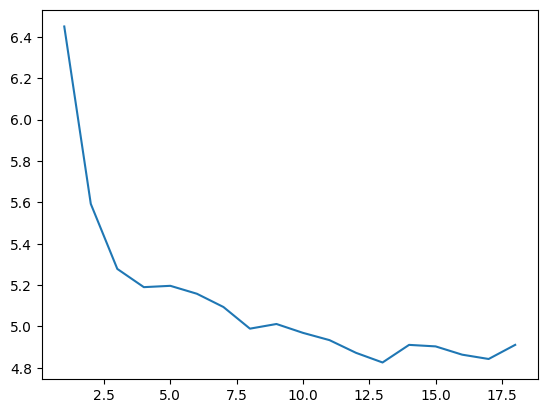

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [29]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model.keras')


### Predicción del próximo caracter

> **Conclusión**: En un escenario 1 se entrenó solamente con 10 epochs, y la predicción del próximo carácter era errático. Sin embargo al entrenarlo con 20 epochs, fue más preciso en predecir un carácter correcto de acuerdo al texto.

In [30]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

!pip install -q gradio

In [39]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = [char2idx[ch] for ch in human_text.lower() ]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario el caracter
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    out_word = idx2char[y_hat]

    # Agrego la palabra a la frase predicha
    return human_text + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://66f5a6af29d475109b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://66f5a6af29d475109b.gradio.live


### Generación de secuencias

In [32]:
def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text

In [41]:
input_text='las teorías de la ciencia demuestran'

generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'las teorías de la ciencia demuestran en la cabeza de la cabeza de '

> **Conclusión**: En el primer caso, con Greedy Search, se probaron distintas combinacion de palabras, y sin embargo devolvió repetidamente la secuencia "en la cabeza de la cabeza de ". Confirmándose que con esta técnica puede ser repetitivo.

###  Beam search y muestreo aleatorio

In [34]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

In [35]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens[:,-(len(input)+num_words):]

> **Conclusión**: al aumentar el `num_beans`, hace que el modelo explore más combinaciones, evitando así patrones repetitivos. Sin embargo al mantenerlo en un valor más bajo, daba como resultado generalmente la misma frase repetitiva como lo hace Greedy Search.

In [81]:
# predicción con beam search
salidas = beam_search(model,num_beams=25,num_words=20,input="conversaba con absoluta calma")

In [82]:
salidas[0]

array([49, 61, 18, 73, 54, 58,  1, 69, 32, 69, 48, 49, 61, 18, 48, 69, 32,
        1, 61, 17,  6, 53, 69, 48, 49, 69, 17, 14, 69, 39, 48, 14,  3, 48,
       53, 45, 61, 48, 18, 61, 48, 29, 69, 32, 45, 69, 14, 61,  1])

In [83]:
# veamos las salidas
decode(salidas[0])

'conversaba con absoluta calma. mi tío no habíamos'

In [77]:
# veamos las salidas
decode(salidas[0])

'el túnel, en vez de hundirse en el profesor que '

In [56]:
# veamos las salidas
decode(salidas[0])

'muy pocas personas de las palabras de '

In [53]:
# veamos las salidas
decode(salidas[0])

'ferrocarril y del buque con una especie del '

In [50]:
# veamos las salidas
decode(salidas[0])

'conversaba con absoluta calma de las palabras de '



---


# Observaciones/Conclusiones

> En el pre-procesamiento del texto, se normalizó el texto, eliminando caracteres innecesarios y saltos de línea.

> Se entrenó el modelo y se evidenció una disminución progresiva de la perplejidad, lo cual indica la capacidad del modelo de capturar patrones en el texto.

> En la "predicción del próximo caracter", se entrenó inicialmente solamente con 10 epochs, y la predicción era errática. Sin embargo al entrenarlo con 20 epochs, fue más preciso en predecir un carácter correcto de acuerdo al texto.

> En la "generación de secuencias", con Greedy Search, se probaron distintas combinaciones de palabras, y sin embargo devolvió repetidamente la secuencia "en la cabeza de la cabeza de ".

> En la "generación de secuencias", con "Beam Search", al aumentar el num_beans, hace que el modelo explore más combinaciones, evitando así patrones repetitivos. Sin embargo al mantenerlo en un valor más bajo, daba como resultado generalmente la misma frase repetitiva.

---